In [1]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
import torch
from PIL import ImageFont, ImageDraw, Image
import difflib

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
path = "./DATA/train/바실리포미스캡슐/K-038910_0_0_0_2_90_300_200.png"
ocr_list=[]

#https://dsbook.tistory.com/171

with open(path, 'rb') as f:
    data = f.read()
encoded_img = np.fromstring(data, dtype = np.uint8)
org_image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
ret,th1=cv2.threshold(org_image,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
th2=cv2.adaptiveThreshold(org_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,2)
th3=cv2.adaptiveThreshold(org_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
th4=cv2.adaptiveThreshold(org_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,15,2)
th5=cv2.adaptiveThreshold(org_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,15,2)

titles=['Original','Mean','Guassian','Global','Mean_INV','Guassian_INV']
images=[org_image,th2,th3,th1,th4,th5]

object_text=[
    [["ETEX G5"],'바실리포미스캡슐'],
    [["GUJU BIO"],'비오메틱스캡슐(바실루스리케니포르미스균)'],
    [["E","10"],'에피나레정'],
    [["DWB","20"],'크라틴정 20mg'],
    [["TPT"],'티아프란정'],
    ]
object_type=["바실리포미스캡슐",
             "비오메틱스캡슐(바실루스리케니포르미스균)",
             "에피나레정",
             "크라틴정 20mg",
             "티아프란정"]

object_acc={object_type[i]:0 for i in range(len(object_type))}

for i in range(0,6):
    langs = ['en']
    cv2.imwrite('./static/uploads/ocrtest.png',images[i])
 
    print("[INFO] OCR'ing input image...")

    path="./static/uploads/ocrtest.png"
    with open(path, 'rb') as f:
        data = f.read()
    ocr_encoded_img = np.fromstring(data, dtype = np.uint8)
    ocr_image = cv2.imdecode(ocr_encoded_img, cv2.IMREAD_COLOR) 

    Shape=ocr_image.shape
    #ocr_image = ocr_image[70:Shape[0]-80,25:Shape[1]-25]

    reader = Reader(lang_list=langs, gpu=True)
    results = reader.readtext(ocr_image)
    simple_results = reader.readtext(ocr_image, detail = 0)
    print(simple_results)
    ocr_list.append(simple_results)
    #simple_results[0]
    TEXT=""
    for i in range(len(simple_results)):
        TEXT+=simple_results[i]

    answer_string = TEXT

    for ocr_text in object_text:
        for text in ocr_text[0]:

            input_string = text

            answer_bytes = bytes(answer_string, 'utf-8')
            input_bytes = bytes(input_string, 'utf-8')
            answer_bytes_list = list(answer_bytes)
            input_bytes_list = list(input_bytes)

            sm = difflib.SequenceMatcher(None, answer_bytes_list, input_bytes_list)
            similar = sm.ratio()

            object_acc[ocr_text[1]]=max(object_acc[ocr_text[1]],float(similar))

print(object_acc)
        
    



[INFO] OCR'ing input image...


C:\Users\white\AppData\Local\Temp\ipykernel_18208\3338353389.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(data, dtype = np.uint8)
C:\Users\white\AppData\Local\Temp\ipykernel_18208\3338353389.py:44: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ocr_encoded_img = np.fromstring(data, dtype = np.uint8)


['65', 'ETEX']
[INFO] OCR'ing input image...
['G5', "'ETEX ", '}']
[INFO] OCR'ing input image...
['(5', "'ETEX:"]
[INFO] OCR'ing input image...
['65', 'ETEX']
[INFO] OCR'ing input image...
['65', '0', 'ETEX _']
[INFO] OCR'ing input image...
['05', 'ETEX :']
{'바실리포미스캡슐': 0.6666666666666666, '비오메틱스캡슐(바실루스리케니포르미스균)': 0.23529411764705882, '에피나레정': 0.2857142857142857, '크라틴정 20mg': 0.2, '티아프란정': 0.2222222222222222}


In [4]:
path="./test_image.png"
with open(path, 'rb') as f:
    data = f.read()
ocr_encoded_img = np.fromstring(data, dtype = np.uint8)
ocr_image = cv2.imdecode(ocr_encoded_img, cv2.IMREAD_COLOR) 

reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(ocr_image)
simple_results = reader.readtext(ocr_image, detail = 0)
print(simple_results)

C:\Users\white\AppData\Local\Temp\ipykernel_18208\3008036964.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ocr_encoded_img = np.fromstring(data, dtype = np.uint8)


[]


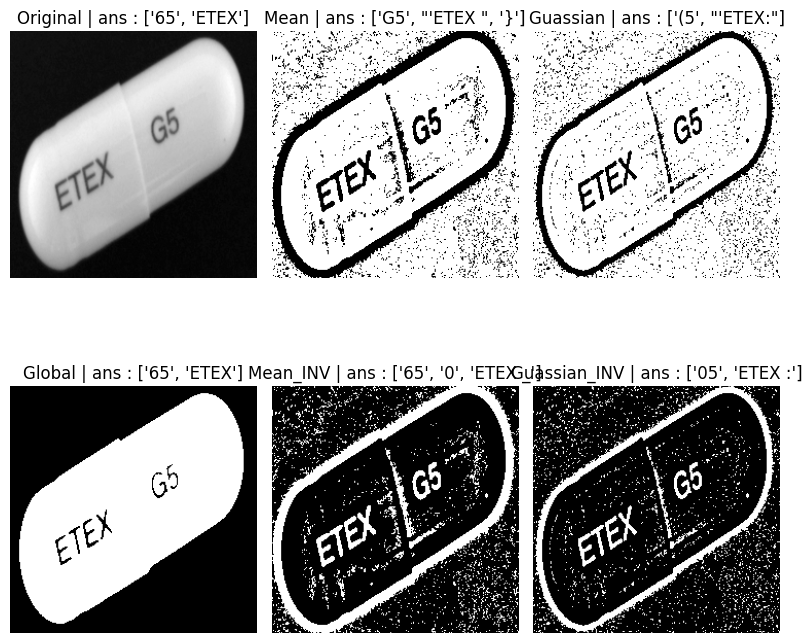

In [5]:
plt.figure(figsize=(8,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],cmap='gray')
    plt.title(titles[i]+f" | ans : {str(ocr_list[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()